# Fundamentos de SPARK

### ¿Que es Apache Spark?

**Apache Spark** es un motor de procesamiento de datos que fue diseñado para trabajar con *grandes cantidades* de datos que no caben en una única computadora , por tanto distribuyen el contenido en varias máquinas, usando activamente su *memoria RAM*, a esto se le denomina *Clusters*. Esto permite analizar terabytes de datos en segundos. 

**Spark es una herramienta que permite el procesamiento de datos de manera paralela y veloz**
Sin embargo cabe aclarar que, es posible trabajar en *Disco*, pero , en *memoria RAM* vamos a ganar velocidad , pero a un mayor costo

### ¿Donde se usa?

Se usa para tareas de **Big Data**
1. **ETL Process**: Se usa para mover grandes cantidades de datos , por ejemplo desde una base de datos con archivos, datos, imagenes, para luego *Limpiarlos* , *Modificarlos* y *Cargarlos* por ejemplo a un *DataWereHouse*
2. **Análisis exploratorio de datos**: Analístas y científico de datos lo utilizan para consultar y explorar grandes datasets de manera rápida
3. **Machine Learning**: Mediante la librería MLlib, es posible entrenar modelos de aprendizaje automático usando enormes volúmenes de datos 
4. **Procesamiento en tiempo real** : Analizar datos que llegan contínuamente , tales como clics en una página web, transacciones bancarias o datos de sensores.

*Empresas de streaming lo usan para sistemas de recomendación y análisis de comportamiento de usuarios*

1. **Cluster** : Es el conjunto de todas las máquinas
2. **Nodo Worker**: Es una máquina individual *(Física o virtual)* dentro de un cluster
3. **Executor**: Es un proceso que Spark lanza en un nodo worker. Es el encargado de ejecutar el trabajo. Un nodo puede tener uno o más executors
4. **Core/CPU**: Es la capacidad de procesamiento del executor. Un executor con 8 cores puede procesar 8 tareas en paralelo
5. **Task(Tarea)**: Es una unidad de trabajo que procesa una *partición* de datos

### Particiones

Una partición es un **bloque lógico de los datos** *(ya sea un RDD o un dataFrame)*. Es la unidad mínima de **paralelismo** en Spark. Significa que cada partición será procesada por una única tarea *(task)* a la vez

**Nivel de paralelismo** : El número de particiones determina cuántas tareas se pueden ejecutar en paralelo. Es decir , si se tienen 4 particiones , pero 100 cores , se desperdiciarían 96 cores.

**Uso de memoria** : El tamaño de cada participación influye en la cantidad de memoria que cada tarea necesita. Particiones muy grandes pueden saturar la memoria

**DataFrame**: En cuanto a su estructura es el típico archivo `.csv` que tiene filas y columnas, solo que en *Spark* está distribuido en muchas computadoras a partir de los *Clusters de datos*

**Cluster** : Es un conjunto de máquinas que trabajan como si fuesen una sola y cada máquina se reconoce como *nodo*

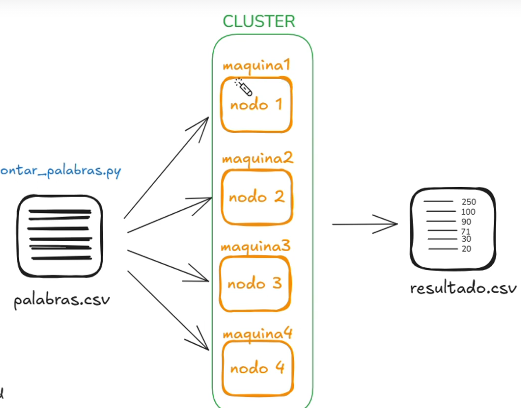

#### Resilient distributed dataset (RDD)

Es una colección de datos tolerante a fallos y que es capaz de operar en paralelo

*Características*
* Es el tipo base de datos en spark
* Son datos **distribuidos** entre todos los clusters
* Son **inmutables** una vez creados no se pueden modificar
* El RDD está particionado en los nodos del clúster y por eso se dice que es  resiliente, porque si perdemos parte del fichero podemos recuperarlo a partir de las réplicas de los otros nodos
* También se dice que es resiliente por el DAG (Direct Acyclic Graph), es el registro de las transformaciones por las que pasa un RDD , por lo que si se pierde información , Spark puede recuperar información a partir del DAG

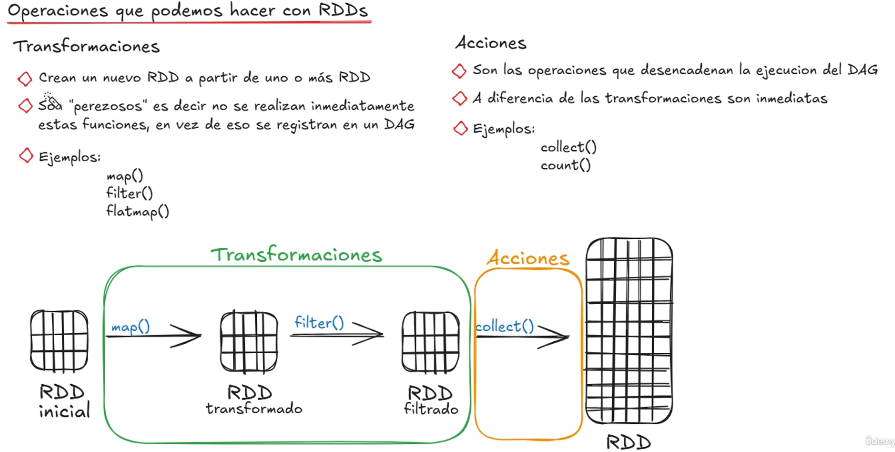

**DataBrics**: Configuración de los cluster de datos, plataforma que se encarga de esta configuración en la nube

#### ¿Cuando usar RDD?

* Cuando interese controlar el flujo de spark
* Cuando se usa Python , dado que hay un mejor control de los datos
* Cuando se está conectado a versiones antiguas de spark

#### ¿Cuando usar DataFrames?

* Si poseeemos semánticas de datos complicados
* Se van a realizar tareas como filtros, mapeos, agregaciones, promedios o sumas
* Si vamos a usar sentencias SQL `LIKE`

#### Transformaciones

Las transformaciones son **instrucciones perezosas** *lazy*, que definen un nuevo conjunto de datos a partir de uno existente. Toman un RDD o un dataFrame y producen uno nuevo, sin embargo, no se ejecuta  solo se define un plan de ejecución

**Narrow (Angostas)** : Son operaciones rápidas donde cada partición de entrada calcula su resultado de forma independiente, sin necesidad de comunicarse con otras.

> No hay movimiento de datos entre los nodos del cluster. Sin intercambio de datos entre particiones (No shuffle(Barajar)). Cada partición de entrada tiene todo lo que necesita para calcular su correspondiente partición de salida.

> **Rendimiento**: Son muy rápidas y eficientes porque todo se puede hacer en paralelo y en memoria sin esperar a otros nodos
> **Aplicación**: Se usan para limpiar, filtrar o enriquecer datos registro por registro, ejemplos de esto son `map`, `filter`, `flatMap`, `union`

**Wide | Shuffle (Anchas)** : Son operaciones costosas que requieren que Spark mueva y reorganice datos entre todas las particiones, un proceso conocido como **Shuffle**. Los datos de varias particiones de entrada se necesitan para calcular una única partición de salida, esto obliga a Spark a redistribuir los datos a través del cluster.

> Requieren un *Shuffle* . Spark debe leer todos los datos , agrupados por una clave y moverlos entre los nodos
> **Rendimiento** : Son lentas y costosas. El shuffle implica mover datos por la red y escribirlos en el disco , lo que representa el *cuello de botella*

> **Aplicación**: Se usan para cualquier operación que necesite agrupar o comparar datos a través de todo el conjunto de datos como `groupByKey`, `reduceByKey`, `aggregateByKey`, `join`, `distinct`, `repartition`

> Debe reducirse el número de Shuffles en cada aplicación escrita en Spark

### Acciones

Son aquellas que **ordenan** a Spark **ejecutar** **las transformaciones** y devolver un resultado

Estas acciones disparan el computo de manera inmediata *(son eager (ansiosas))* y escriben el resultado en un sistema de almacenamiento (NO devuelven un dataFrame)

Ejemplo : `count`, `collect`, `take`, `first`, `save`

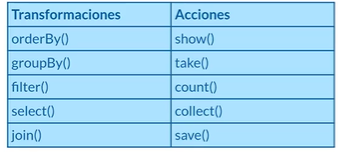

### **Ejemplo aplicado**

**Ejemplo aplicado**:  Supongamos que tenemos un set de datos de usuarios y queremos contar cuantos son mayores de 30 años. y vamos a usar Spark para solucionar este problema

In [1]:
#Hacemos uso de PySpark SQL
from pyspark.sql import SparkSession

In [2]:
# 1. Iniciar una sesión de Spark (es el punto de entrada)
spark = SparkSession.builder.appName("ExampleUsers").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/19 12:42:12 WARN Utils: Your hostname, TECNICA, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/19 12:42:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/19 12:42:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 2. Crear un DataFrame de ejemplo (en un caso real, leerías un archivo)
data = [("Juan", 28), ("Ana", 35), ("Pedro", 41), ("Maria", 22)]
columnas = ["nombre", "edad"]
df = spark.createDataFrame(data, schema=columnas)

In [4]:
print("Datos originales:")
df.show()

Datos originales:


+------+----+
|nombre|edad|
+------+----+
|  Juan|  28|
|   Ana|  35|
| Pedro|  41|
| Maria|  22|
+------+----+



In [5]:
# 3. Aplicar una transformación: filtrar los mayores de 30
df_mayores_30 = df.filter(df.edad > 30)

In [6]:
print("Usuarios mayores de 30:")
df_mayores_30.show()

Usuarios mayores de 30:
+------+----+
|nombre|edad|
+------+----+
|   Ana|  35|
| Pedro|  41|
+------+----+



In [7]:
# 4. Aplicar una acción: contar el resultado
total = df_mayores_30.count()
print(f"Total de usuarios mayores de 30: {total}")

Total de usuarios mayores de 30: 2


In [8]:
# 5. Detener la sesión
spark.stop()

**Lazy evaluation(Evaluación perezosa)**: Esto significa que no ejecuta nada hasta que sea estrictamente necesario

**Transformaciones**: Son operaciones que definen un nuevo *dataframe* a partir de otro. Spark no ejecuta al instant las transformaciones , solo construye un plan de lo que tiene que hacer
    *Ejemplos* -> `filter()` (filtrar fias), `select()` (Elegir columnas), `group_by()` (Agrupar)

**Acciones**: Son operaciones que devuelven *un resultado final* que si se ejecutan al instante
    *Ejemplos* -> `count()`(contar filas), `show()` (mostrar datos en pantalla), `collect()` (traer los datos de la máquina principal), `save()` (guardar el resultado) 